In [1]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [16]:
from typing import Any
import usbtmc
import numpy as np
import time

class Oscilloscope(usbtmc.Instrument):
    def __init__(self, vendor_id, product_id, timeout=2):
        """
        Initialize the oscilloscope instrument.

        :param vendor_id: The vendor ID of the oscilloscope.
        :param product_id: The product ID of the oscilloscope.
        :param timeout: Communication timeout in seconds.
        """
        super().__init__(vendor_id, product_id)
        self.timeout = timeout
        self.write('*CLS')  # Clear the status
        self.write(':system:header off')
        self.write(':waveform:streaming ON')  # Enable waveform streaming
        self.write(':waveform:byteorder lsbfirst')
        self.write(':waveform:format word')  # Set waveform format to 16-bit word
        # self.write(':wav:uns 1')  # Unsigned data format

    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.close()
        super().__exit__(exc_type, exc_value, traceback)
    
    def __getattribute__(self, name: str) -> Any:
        # specific procedures to do before returning variable
        match name:
            case 'instrument_name':
                self.instrument_name=self.ask('*IDN?')
            case 'analog_sample_rate':
                self.analog_sample_rate=float(self.ask(':acquire:srate:analog?'))
            case 'digital_sample_rate':
                self.digital_sample_rate=float(self.ask(':acquire:srate:digital?'))
        
        return super().__getattribute__(name)
    

    def fetch_x_data(self):
        """
        Fetch X-axis data (time data) from the oscilloscope.

        :return: Numpy array of X-axis data (time points).
        """
        x_increment = float(self.ask(":WAV:XINC?"))
        x_origin = float(self.ask(":WAV:XOR?"))
        x_reference = float(self.ask(":WAV:XREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Generate the time (X-axis) data array
        x_data = np.arange(num_points) * x_increment + x_origin - x_reference * x_increment
        return x_data

    def fetch_y_data(self, channel=1):
        """
        Fetch Y-axis data (voltage data) from the oscilloscope for a specified channel.

        :param channel: The channel number to fetch data from (default is 1).
        :return: Numpy array of Y-axis data (voltage points).
        """
        # Set the channel to read from
        self.write(f":WAV:SOUR CHAN{channel}")

        # Get Y data scaling parameters
        y_increment = float(self.ask(":WAV:YINC?"))
        y_origin = float(self.ask(":WAV:YOR?"))
        y_reference = float(self.ask(":WAV:YREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Request the waveform data
        self.write(":WAV:DATA?")
        raw_data = self.read_raw()  # Read raw data

        # Process the raw data
        header_size = 2  # Standard header size for 16-bit word data
        data_size = len(raw_data) - header_size - 1
        if data_size != num_points * 2:  # 16-bit data means 2 bytes per point
            raise ValueError(f"Mismatch in data length: expected {num_points * 2}, got {data_size}")
        
        # Convert raw data to a numpy array of 16-bit unsigned integers
        y_data = np.frombuffer(raw_data[header_size:-1], dtype=np.int16)
        # y_data = np.frombuffer(raw_data, dtype=np.int16, header_size=2)

        # Scale the data to get the correct voltage values
        y_data = (y_data - y_reference) * y_increment + y_origin
        return y_data

    def wait_for_trigger(self, timeout=5):
        """
        Wait for the oscilloscope to trigger before fetching data.

        :param timeout: Maximum time to wait for a trigger, in seconds.
        :return: True if triggered, False if timeout occurs.
        """
        self.write(':TRIG:MODE EDGE')  # Set trigger mode to edge
        self.write(':TRIG:SOUR CHAN1')  # Set trigger source to channel 1 (customize as needed)
        self.write(':TRIG:LEV 0.5')  # Set trigger level (customize as needed)

        elapsed_time = 0
        poll_interval = 0.1  # Poll every 100 ms
        while elapsed_time < timeout:
            # Check trigger status
            status = int(self.ask(':TER?'))
            if status == 1:  # Status 1 indicates the oscilloscope has triggered
                return True
            time.sleep(poll_interval)
            elapsed_time += poll_interval
        
        # Timeout occurred
        return False

# Example usage:
# osc = Oscilloscope(vendor_id=0x1234, product_id=0x5678)
# x_data = osc.fetch_x_data()
# y_data = osc.fetch_y_data(channel=1)
# osc.close()


In [17]:
scope.close()
scope = Oscilloscope(vendor_id=0x0957, product_id=0x900d)

In [11]:
x=scope.fetch_x_data()
x

array([-0.00210282, -0.00210281, -0.0021028 , ...,  0.00789718,
        0.00789719,  0.0078972 ])

In [26]:
import decimal
print(
    decimal.Decimal(scope.analog_sample_rate).normalize().to_eng_string(),
    decimal.Decimal(scope.digital_sample_rate).normalize().to_eng_string()
)

100E+6 2E+9


In [6]:
from IPython.display import clear_output

while True:
    clear_output(wait=True)
    scope.wait_for_trigger()
    y=scope.fetch_y_data()
    

    plt.xticks(rotation=45)

    mid = len(x)//2
    plot(x[mid:mid+150], y[mid:mid+150], lw=1)
    plt.show()


KeyboardInterrupt: 

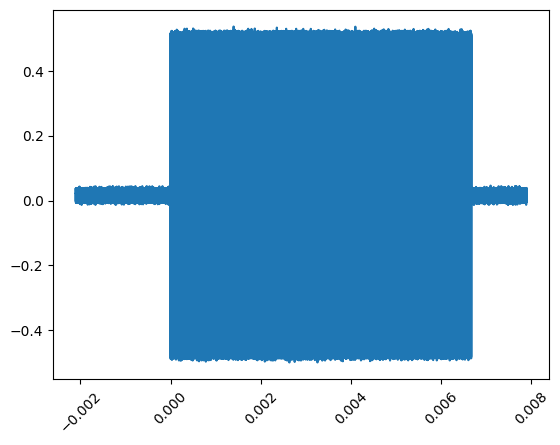

In [ ]:
plt.xticks(rotation=45)
plot(x, y)

In [ ]:
class OscilloscopeProcessManager:
    